# makemore part 3
mlp cont. - Activations, Gradients, BatchNorm, and Pytorch

In [1]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(words)

32033

In [72]:
# build the vocab and mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:(i+1) for i,s in enumerate(chars)}; stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(f'num of chars (and the special char .): {len(stoi)}')
vocab_size = len(stoi)

num of chars (and the special char .): 27


In [5]:
def build_dataset(words, block_size):
#     block_size = 3 # context length, which is the num of chars we take to predict the next char
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# data split: 80, 10, 10
block_size = 3
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# mlp def:
g = torch.Generator().manual_seed(2147483647)
n_embd = 10
n_hidden = 200

# model params:
C = torch.randn((27,n_embd), generator=g) 
W1 = torch.randn((block_size*n_embd, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [7]:
# model training:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch contruct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] 
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < (max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # stats
    if i % (max_steps/20) == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item()) #log loss is less hockey stick like in the graph than just loss
    
#     break
    

      0/ 200000: 27.8817
  10000/ 200000: 2.8598
  20000/ 200000: 2.5249
  30000/ 200000: 2.8522
  40000/ 200000: 2.0585
  50000/ 200000: 2.5718
  60000/ 200000: 2.3764
  70000/ 200000: 2.1211
  80000/ 200000: 2.2893
  90000/ 200000: 2.3247
 100000/ 200000: 2.0574
 110000/ 200000: 2.4674
 120000/ 200000: 1.9108
 130000/ 200000: 2.4755
 140000/ 200000: 2.1971
 150000/ 200000: 2.1689
 160000/ 200000: 2.1055
 170000/ 200000: 1.8050
 180000/ 200000: 2.0539
 190000/ 200000: 1.8716


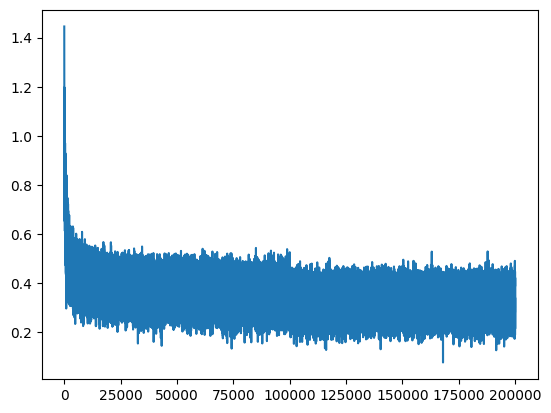

In [8]:
_ = plt.plot(lossi)

In [9]:
@torch.no_grad() # disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    } [split]
    
    # forward pass (evalution)
    emb = C[x] 
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())
    

In [10]:
split_loss('train')
split_loss('val')

train 2.127263069152832
val 2.1711132526397705


In [11]:
for _ in range(10):
    out = []
    context = [0] * block_size # init . . .
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)[:-1])

milea
kynn
eithi
demellen
eathakwisie
cary
hoa
addayla
alshir
nyda


## problem 1: fixing the initial loss
on epoch 0, the training loss is very high ~27. we expect it to be ~3.3 because our probs should be uniform (-ly bad). the reason for 3 is that we have 27 characters, at uniform dist we expect to get 1/27 probability, therefore the loss should be -log(1/27). we want our init logits to come out as 0s.

In [12]:
# 4-dim example of the issue
y_true = random.randint(0,3)
print(f"y_true = {y_true}", end='\n\n')
# good init:
print("good init")
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
print(f'probs: {probs}')
loss = -probs[y_true].log()
print(f'loss: {loss}', end='\n\n')

# bad init:
print("bad init")
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
print(f'probs: {probs}')
loss = -probs[y_true].log()
print(f'loss: {loss}')

y_true = 2

good init
probs: tensor([0.2500, 0.2500, 0.2500, 0.2500])
loss: 1.3862943649291992

bad init
probs: tensor([2.7178e-07, 3.9567e-11, 4.2831e-13, 1.0000e+00])
loss: 28.478927612304688


how do we make the probs be uniform? we need to make the logits uniform. 

how do we make the logits uniform? logits = h @ W2 + b2. therefore, we need to make W2 be close to 0, and b2 be 0 at init.

note: we don't want to make W2 be 0 at init.

In [13]:
# mlp def, with good init:
g = torch.Generator().manual_seed(2147483647)
n_embd = 10
n_hidden = 200

# model params:
C = torch.randn((27,n_embd), generator=g) 
W1 = torch.randn((block_size*n_embd, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

## problem 2: saturated tanh / relu / sigmoid
recall $tanh(x)\in [-1,1]$ for any $x \in R$.

**why is a saturated tanh bad?** recall that the backward step in gd for a tanh node is `self.grad += (1-tanh(x)**2) * out.grad`. if tanh is equal to either 1 or -1 (or close to it), the self.grad will be equal to 0, which means that the tanh node will propagate a 0 as it's gradient, effectively killing the gradient.

**dead neurons**: below is an image of h (32 x 200) showing in white where tanh in abs is above 0.99. notice how each column in the matrix corresponds to a neuron in the first layer. if a neuron / column has all of its tanh values be above 0.99 (in abs), then no example will ever cause it to change because the backwards gradient will always die.

By visualizing h, we can see that the majority of the values are -1 or 1, aka h is saturated.

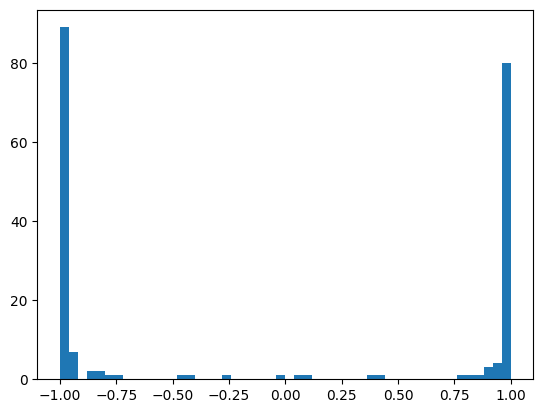

In [14]:
plt.hist(h.view(-1).tolist(), 50);

hpreact (h before tanh) has a wide distribution of values (between -20 and 20). this causes the tanh to squash hpreact and might cause a lot of -1s and 1s.

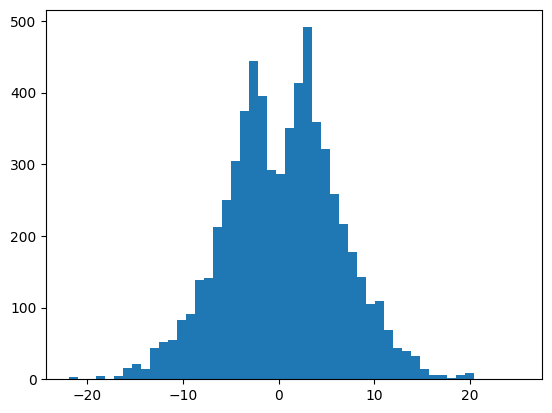

In [15]:
plt.hist(hpreact.view(-1).tolist(), 50);

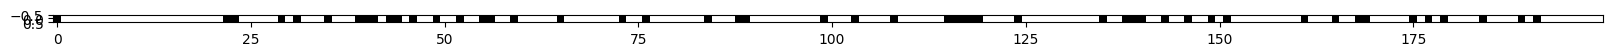

In [16]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');
# white if above 0.99, black otherwise
# we see a lot of white. 
# in each case where the tanh abs value is above 0.99, the backward gradient will get destroyed

fundamentally, we have the same problem as the bad init: hpreact has value that are too large, in abs value. because `hpreact = embcat @ W1 + b1`, we want to squash W1 and b1. this time it's ok if b1 is not 0 (for some good entropy), and that W1 is not super close to 0, just as long as the majority of the weights will not be saturated by the tanh.

In [17]:
# mlp def, with good init and fixing the saturated tanh:
g = torch.Generator().manual_seed(2147483647)
n_embd = 10
n_hidden = 200

# model params:
C = torch.randn((27,n_embd), generator=g) 
W1 = torch.randn((block_size*n_embd, n_hidden), generator=g) * 0.002
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

## How to properly init the network using Kaiming init

In [18]:
# example:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
print(f'mean and stf of x: {x.mean()}, {x.std()}') 
print(f'mean and stf of w: {w.mean()}, {w.std()}', end='\n\n')

y = x @ w
print("y before kaiming init")
print(f'mean and stf of y: {y.mean()}, {y.std()}', end='\n\n') 
# notice how the mean of y stays at 0 (@ is a symmetric operation), but the std gets bigger.
# we want to keep the std (spread) of y to be around 1.

w = w / 10**0.5 # the 'fan in' of w is 10. so we divide by the sqrt(fan_in) = sqrt(10).
y = x @ w
print("y after kaiming init")
print(f'mean and stf of y: {y.mean()}, {y.std()}') 
# now y is normal


mean and stf of x: 0.004731904715299606, 0.997572124004364
mean and stf of w: 0.013584963046014309, 0.9996063709259033

y before kaiming init
mean and stf of y: 0.004765931982547045, 3.157407522201538

y after kaiming init
mean and stf of y: 0.0015071200905367732, 0.9984599351882935


according to kaiming we want to multiply the weights by:
$$std=\frac{gain}{\sqrt{fan\_in}}$$

the gain for tanh is $\frac{5}{3}$ and all together we multiply by $\frac{5/3}{\sqrt{3\cdot10}}$ = ~0.3.

In [19]:
# mlp def, with good init and fixing the saturated tanh using kaiming:
g = torch.Generator().manual_seed(2147483647)
n_embd = 10
n_hidden = 200

# model params:
C = torch.randn((27,n_embd), generator=g) 
W1 = torch.randn((block_size*n_embd, n_hidden), generator=g) * (5/3)/(block_size*n_embd)**0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

## BatchNorm - layers that help in training, usually placed after multipication layers (conv, Linear, etc.)
we can normalize every batch, because normalizing (subtract mean and divide by the std of the batch) is differentiable. now the examples within the same batch are effecting each other (could be seen as good because it acts as a regulizer).

in our nn, we want to do this for hpreact, because if a value going into tanh is too small, tanh effectively does nothing $(1-0^2)\cdot out.grad = out.grad$, and if the abs(value) is very big, tanh will kill it.

we'll do this during training.

we don't want to exactly get a mean of 0 and an std of 1 for every batch, instead we want to let the nn during backprop learn the dist. meaning that the dist. can shift / widen etc. we will add 2 learned params: $\gamma$ that will scale and $\beta$ that will shift the normalized batch. i.e. $y_i \leftarrow \gamma \hat{x_i} + \beta$.

In [58]:
# mlp def, with good init and fixing the saturated tanh using kaiming, and batchnorm:
g = torch.Generator().manual_seed(2147483647)
n_embd = 10
n_hidden = 200

# model params:
C = torch.randn((27,n_embd), generator=g) 
W1 = torch.randn((block_size*n_embd, n_hidden), generator=g) * (5/3)/(block_size*n_embd)**0.5
# b1 = torch.randn(n_hidden, generator=g) * 0.01  # see note below
W2 = torch.randn((n_hidden, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0

# BatchNorm Layer params:
# at init, hpreact will be normalized, but the nn will learn the right params later in training.
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

small note about bias and BatchNorm: we no longer need to add b1. this is because it will be removed in hpreact_normalized by the bnmean_i. in general, when using batchnorm, there is no need for bias in the layer before. (you can see this by `b1.grad` which is all 0s)

In [60]:
# model training:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch contruct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] 
    embcat = emb.view(emb.shape[0], -1)
    
    # ---- Linear Layer -------
    hpreact = embcat @ W1 #+ b1 see note above
    
    # ---- BatchNorm Layer ----
    bnmean_i = hpreact.mean(dim=0, keepdim=True) # mean per batch 
    bnstd_i = hpreact.std(dim=0, keepdim=True) # std per batch 
    # update the running mean and std: (with momentum)
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmean_i
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd_i
    hpreact_normalized = bngain * ((hpreact  - bnmean_i) / bnstd_i) + bnbias
    
    # ---- non-linearity ------
    h = torch.tanh(hpreact_normalized)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < (max_steps/2) else 0.01
    for p in parameters:
        if p.grad is None:
            print(p)
        p.data += -lr * p.grad
        
    # stats
    if i % (max_steps/20) == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item()) #log loss is less hockey stick like in the graph than just loss
    
#     break
    

      0/ 200000: 3.2736
  10000/ 200000: 2.3246
  20000/ 200000: 2.0229
  30000/ 200000: 2.0292
  40000/ 200000: 2.0587
  50000/ 200000: 2.8989
  60000/ 200000: 2.1025
  70000/ 200000: 2.8280
  80000/ 200000: 2.5755
  90000/ 200000: 2.2545
 100000/ 200000: 2.0482
 110000/ 200000: 1.8211
 120000/ 200000: 1.8397
 130000/ 200000: 2.4059
 140000/ 200000: 2.4866
 150000/ 200000: 2.4214
 160000/ 200000: 2.1187
 170000/ 200000: 2.1708
 180000/ 200000: 2.1542
 190000/ 200000: 2.0988


we got a problem regarding the batchnorm layer during test time, what values do we use? we are only given one example to run a forward pass on, and not a full batch of examples... we'll use the mean and std of the whole train set.

below is how to do it at the end of training, but it is more efficient to do a running mean/std during training.

In [61]:
# calibrate the batch norm at the end of training
with torch.no_grad():
    # pass teh training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean and std of the entire training set Xtr
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    
# how similar are the running vs. true stats? pretty close
diff_mean = torch.sum((bnmean_running - bnmean)**2)
diff_std = torch.sum((bnstd_running - bnstd)**2)
print(f'diff in mean: {diff_mean}, diff in std: {diff_std}')

diff in mean: 0.04073284566402435, diff in std: 0.11693449318408966


In [62]:
# update the testing funcs forward pass to have a batchnorm layer
@torch.no_grad() # disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    } [split]
    
    # forward pass (evalution)
    emb = C[x] 
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact_normalized = bngain * ((hpreact  - bnmean_running) / bnstd_running) + bnbias
    h = torch.tanh(hpreact_normalized)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())
    

In [63]:
split_loss('train')
split_loss('val')

train 2.0673139095306396
val 2.105573892593384


## Pytorch-ifying the Code:
with pytorch style code we can make a deep mlp

In [92]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in**0.5) #kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(dim=0, keepdim=True) # mean of each batch
            xvar = x.std(dim=0, keepdim=True) # var of each batch
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize the input x
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + (self.momentum)*xmean
                self.running_var = (1-self.momentum)*self.running_var + (self.momentum)*xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
    
class Tanh:    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
    

In [134]:
# deep mlp init

# nn params:
n_embd = 10 #embedding dim
n_hidden = 100 # number of neurons in the hidden layer
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
#     layers[-1].weight *= 0.1
    # for all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # stops the squashing of values, tanh(x) wont get too close to 0
            # if we mult. by a big number, the tanh layers will be saturated
            # 5/3 is a good middle ground
#             layer.weight *= 5/3
            pass

parameters = [C] + [p for layer in layers for p in layer.parameters()]

num_of_params = sum(p.nelement() for p in parameters)
print(f'num of params in the deep mlp is {num_of_params}')

for p in parameters:
    p.requires_grad = True

num of params in the deep mlp is 47551


In [135]:
# training:
max_steps = 200_000
batch_size = 32
lossi = []

ud = [] # some ratio??

for i in range(max_steps):
    
    # minibatch contruct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] 
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < (max_steps/2) else 0.01
    for p in parameters:
        if p.grad is None:
            print(p)
        p.data += -lr * p.grad
        
    # stats
    if i % (max_steps/20) == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item()) #log loss is less hockey stick like in the graph than just loss
    
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i>= 1000:
        break
    

      0/ 200000: 3.2904


## plots to look at while training neural networks:
let's do one forward pass (break uncommented) and visualize the gradients. this will help us know if our init of the weights is good or not. BatchNorm should help us not care about how we init our weights in the nn.

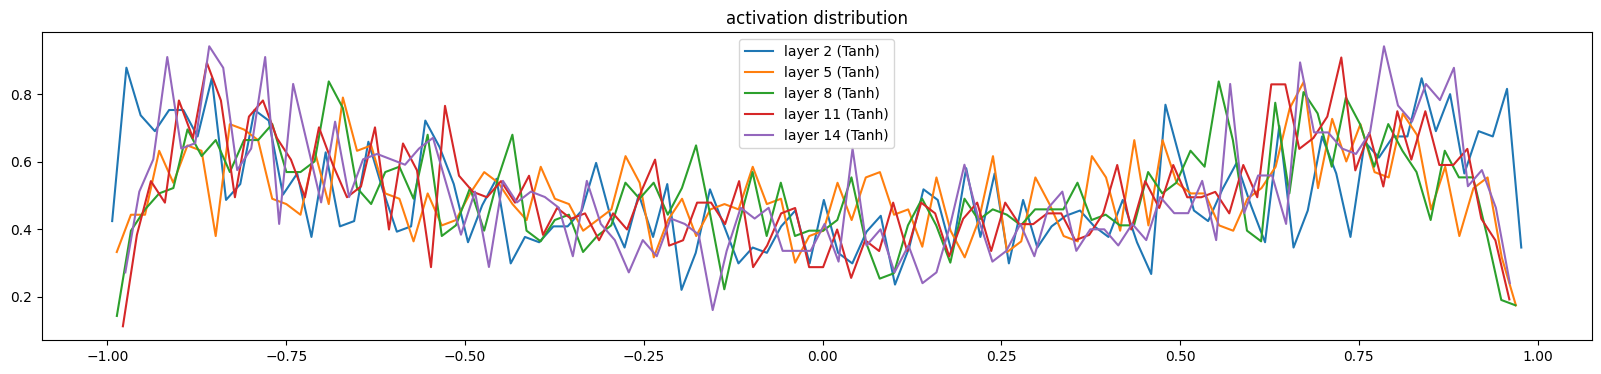

In [136]:
# visualize tanh activations:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out # tanh(x)
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        
plt.legend(legends);
plt.title("activation distribution");

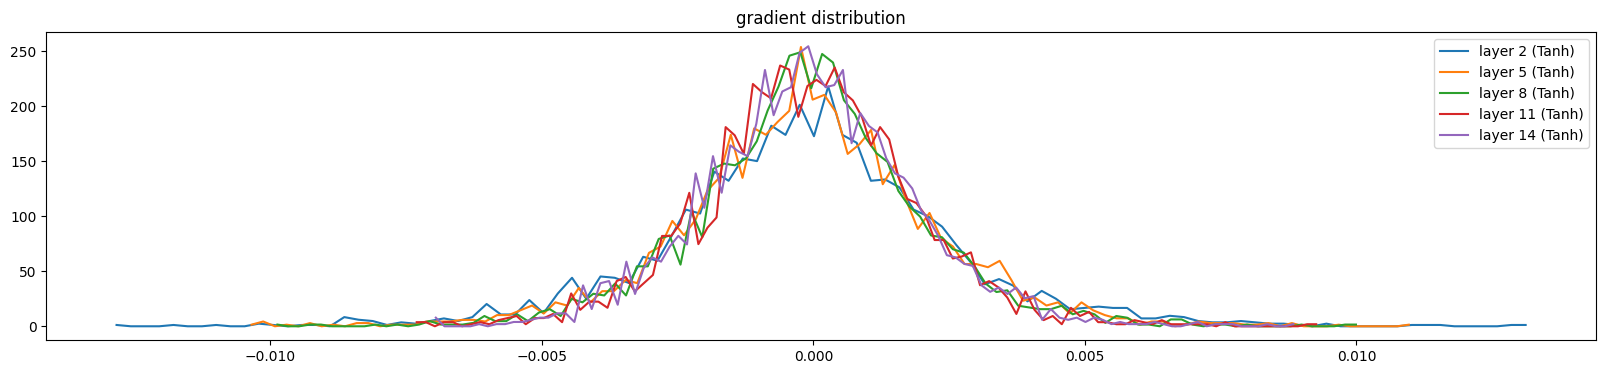

In [137]:
# visualize Tanh gradients:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad # tanh(x).grad
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        
plt.legend(legends);
plt.title("gradient distribution");

# we don't want an exploding or vanishing gradient.
# in this visualization, this would mean that each layer has about the same gradients.

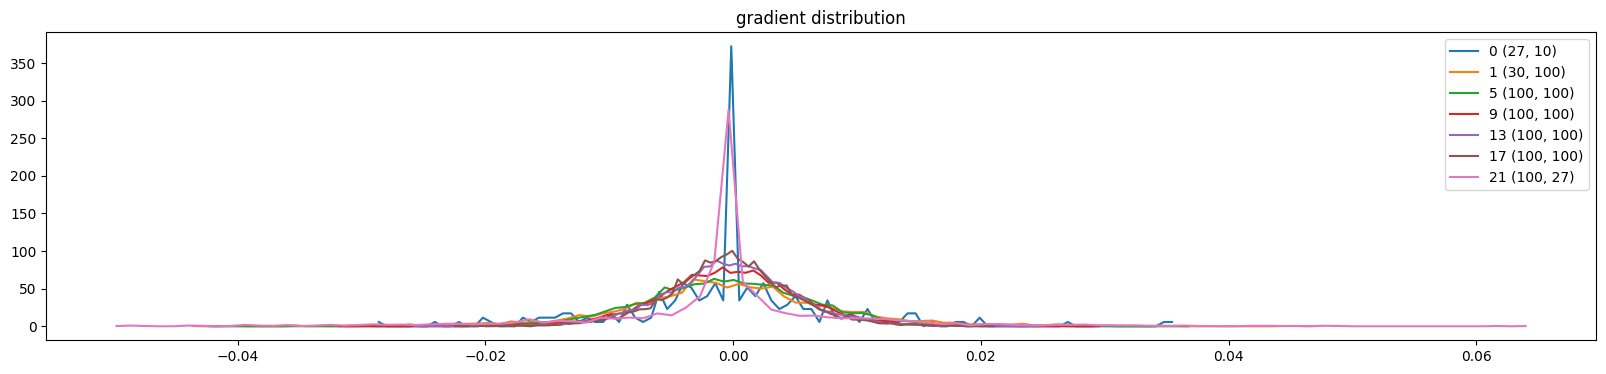

In [139]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: #2d params (just the linear layer params and emb layer)
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
        
plt.legend(legends);
plt.title("gradient distribution");

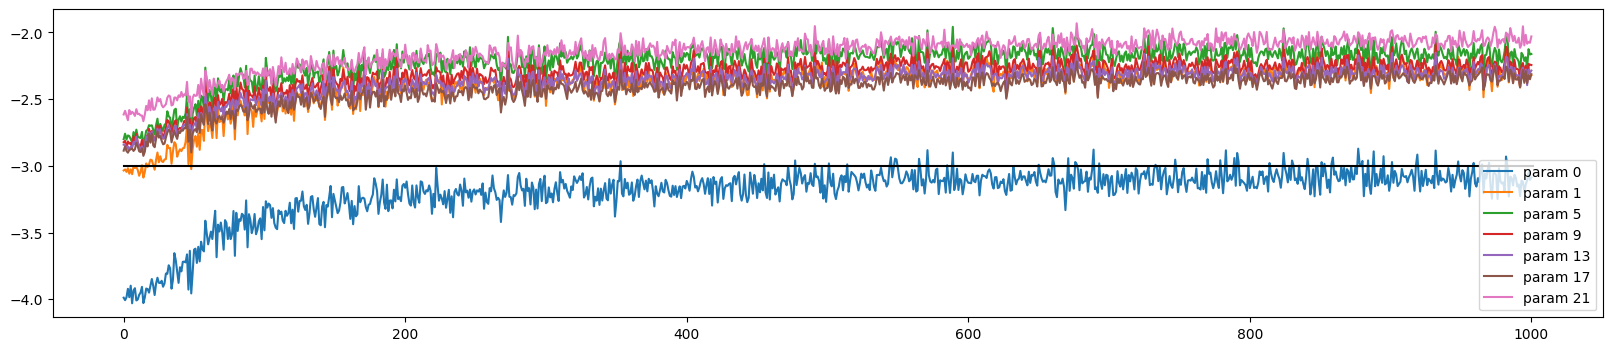

In [140]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2: #2d params (just the linear layer params and emb layer)
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
        
plt.plot([0, len(ud)], [-3,-3], 'k') # ratios should be ~1e-3
plt.legend(legends);
# layers should learn roughly at the same rate